# Electron Cooling

This notebook will serve as a pedagogical example for how electron cooling is performed in the code, as well as the use of the `TransFuncAtRedshift` classes to accomplish this task. 

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

from astropy.io import fits

import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

The ICS transfer function has already been pre-computed, and saved in the `Photon Deposition` Dropbox folder. Change the directory to point to that Dropbox folder on your local computer. 

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

## Transfer Functions

Given an initial electron, if ICS is fast, within the time-step that we are considering, the electron would lose all of its kinetic energy to secondary photons. We want to calculate, among other things, the transfer function $T_{\text{ICS},\gamma}(E_e, E_\gamma)$ that takes us from an input electron spectrum to the fully resolved secondary photon spectrum (after scattering all secondary electrons as well), defined by

$$ \int T_{\text{ICS},\gamma}(E_e, E_\gamma) \frac{dN_e}{dE_e} dE_e = \frac{dN_\gamma}{dE_\gamma} $$

or in its discretized version (discretized transfer functions will always be denoted $\tau$, as opposed to the mathematical continuous transfer function, $T$), 

$$ \frac{dN_\gamma}{dE_\gamma}(E_\gamma^j) = \sum_i \tau_{\text{ICS},\gamma} (E_e^i, E_\gamma^j) \times \frac{dN_e}{dE_e}(E_e^i) \times E_e^i \, d \, \log E_e^i $$

which will be realized as a matrix multiplication in the code. Notice that for a single electron injection at a particular energy $E_e^i$, we get 

$$ \tau_{\text{ICS},\gamma}(E_e^i) = \frac{dN_\gamma}{dE_\gamma}(E_e^i, E_\gamma^j)$$

Thus the resolved secondary photon spectrum for a single electron injection at $E_e^i$ gives exactly the transfer function. 

## Abscissa

We will generate abscissae for the primary electron energy and for the secondary photon energy, as well as set the temperature of the CMB to be the temperature at some arbitrary redshift.

In [4]:
mwimp = 1e13
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng = np.sqrt(englow*enghigh)

mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng_file = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-4)/nphoteng
photenglow = 1e-4*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-4*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng = np.sqrt(photenglow*photenghigh)

rs = 5
T = phys.TCMB(rs)

## ICS Transfer Functions

After a single inverse Compton scattering process, a single electron upscatters a secondary photon from the CMB with final energy $E_\gamma$ and a change in its energy $\Delta$. We have computed both $\frac{dN_\gamma}{dE_\gamma \, dt}$ and $\frac{dN_\gamma}{d\Delta \, dt}$ due to a single electron, and saved them in the `Photon Deposition` Dropbox folder. 

Change the path to point to the local directory corresponding to this folder below. 

In [5]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

These files can be used to generate a `TransFuncAtRedshift` object which stores the spectra referred to above. Because the functions are computed in a limit where the primary electron is nonrelativistic, and another in a limit where it is relativistic, these transfer functions need to be glued together, but we have written special functions to generate a `TransFuncAtRedshift` that contains the appropriate values at all primary electron energies. 

In [6]:
ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

Within `ICS_tf`, we have $\frac{dN_\gamma}{dE_\gamma \, dt} (E_{e,i}, E_\gamma)$ at the abscissae `eleceng` and `photeng`, and likewise `engloss_tf` contains $\frac{dN_\gamma}{d \Delta \, dt} (E_{e,i}, \Delta)$, where $E_{e,i}$ is the energy injected of the primary electron.

## Energy Loss Spectrum to Secondary Electron Spectrum

Now, we want to compute the electron spectrum $\frac{dN_{e,s}}{dE_{e,s} \, dt}$, which is the rate of production of secondary electrons due to the primary cooling by ICS (the subscript *s* is a reminder that we are dealing with secondary electrons). For every photon that gains energy $\Delta$, there is now a secondary electron that has energy $E_{e,i} - \Delta$. Therefore

$$ \frac{dN_\gamma}{d\Delta \, dt} (E_{e,i}, \Delta) d\Delta = \frac{dN_{e,s}}{d E_{e, s} \, dt} (E_{e,i}, E_{e,s} = E_{e,i} - \Delta) dE_{e,s}$$

To do this, we use `Spectrum.engloss_rebin`, which exactly performs this re-definition while conserving number and energy. For each `Spectrum` in `engloss_tf`, which corresponds to some $\frac{dN_\gamma}{d\Delta \, dt}$, simply call the function with two arguments: the injection energy of the primary corresponding to the `Spectrum`, and the final abscissa to rebin into (in this case, we choose `eleceng`). 

In [7]:
# Make a deep copy, so that it is independent of the original engloss_tf. 
sec_elec_tf = tf.TransFuncAtRedshift([])

for i, in_eng in enumerate(engloss_tf.in_eng):
    spec = engloss_tf[i]
    spec.engloss_rebin(in_eng, engloss_tf.in_eng)
    sec_elec_tf.append(spec)

# Elements in sec_elec_tf are Spectrum objects of the secondaries,
# in this case dN/(d Delta dt), ordered by the injection energy of the
# primary, a list of which can be obtained by 
# TransFuncAtRedshift.get_in_eng(). 
# for in_eng, spec in zip(sec_elec_tf.in_eng, sec_elec_tf):
#     spec.engloss_rebin(in_eng, sec_elec_tf.in_eng)

So now `sec_elec_tf` is the discretized version of $\frac{dN_{e,s}}{dE_{e,s} dt}$. 

## Initializing the Loop

We are now ready to compute $\tau_{\text{ICS}}$. First, our code is divided into a high-energy and a low-energy regime. Low-energy photons only undergo photoionization or redshifting, while low-energy electrons cool rapidly via atomic processes, and are processed separately from the high-energy regime. Our goal is to cool the high-energy electrons (which cool very rapidly) into photons and low-energy electrons, and determine the total transfer function for *all* processes, not just ICS.

Here, we define the boundary between high- and low-energy regimes. Conventionally, we define this to be 3 keV, although to compare with the original code, we set it to 250 eV. 

In [8]:
# Low energy regime boundary.
loweng = 250
# List of abscissa values in the high-energy regime. 
eleceng_high = eleceng[eleceng > loweng]
# Indices of abscissa in the high-energy regime. 
eleceng_high_ind = np.arange(eleceng.size)[eleceng > loweng]
# List of abscissa values in the low-energy regime. 
eleceng_low  = eleceng[eleceng <= loweng]
# Indices of abscissa in the low-energy regime. 
eleceng_low_ind  = np.arange(eleceng.size)[eleceng <= loweng]

For ICS, there are four quantities that we are interested in computing. The first is $T_{\text{ICS},\gamma}$, which is the transfer function for scattering a high-energy electron into photons at all energies. We also want $T_{\text{ICS},e}$, which is the transfer function into low-energy electrons. On top of that, we would like to compute $U_{\text{CMB}}$, which is the total initial energy of the CMB photons that are upscattered. We actually know this analytically for the Thomson limit (always true for $\gamma < 20$):

$$ \frac{dU_{\text{CMB}}}{dt} = \sigma_T c \rho_{\text{CMB}} $$

where $\sigma_T$ is the Thomson scattering cross section, and $\rho_{\text{CMB}} = 4 \sigma_{SB} T_{\text{CMB}}^4/c $ is the energy density of the CMB, with $\sigma_{SB}$ is the Stefan-Boltzmann constant. 

All of the quantities are related by energy conservation (remember that for a single primary electron injection, the transfer function is identically the secondary spectrum $dN/dE$):

$$ E_{e,i} + U_{\text{CMB}} = \int T_{\text{ICS},e} E_e \, dE_e + \int T_{\text{ICS},\gamma} E_\gamma \, dE_\gamma $$

However, due to numerical errors, numerically we will find that

$$ E_{e,i} + U_{\text{CMB}}(E_{e,i}) = \int T_{\text{ICS},e}(E_{e,i}) E_e \, dE_e + \int T_{\text{ICS},\gamma}(E_{e,i}) E_\gamma \, dE_\gamma + D(E_{e,i})$$

for some value $D$ as a function of $E_{e,i}$, which we will call "deposited" energy.  

In [9]:
# Empty containers for all quantities to compute.
# tau_{ICS,gamma}
sec_phot_tf = tf.TransFuncAtRedshift([], dlnz=-1, spec_type='N')
# tau_{ICS,e}
sec_lowengelec_tf = tf.TransFuncAtRedshift([], dlnz=-1, spec_type='N')
# U_{CMB}
cont_loss_vec = np.zeros_like(eleceng)
# D
deposited_vec = np.zeros_like(eleceng)

## Low Energy Electrons

Let's start the computation. For low energy primary electrons, we simply want to read them out as a low energy secondary electron, with no scattering into photons. The computation is done by looping over the low energy `eleceng` bins. First, we construct a delta function spectrum, `delta_spec`, with 1's at the index of interest and 0 elsewhere. Then we obtain immediately the low energy electron spectrum (identical to `delta_spec`) and for the photon spectrum (zeros everywhere). These are appended to `sec_phot_tf` and `sec_lowengelec_tf`. When more processes are added, low energy electrons will also have to be scattered and resolved in the same manner as high energy electrons for ICS. 

In [10]:
delta_spec = np.zeros_like(eleceng)
for i,eng in zip(eleceng_low_ind, eleceng_low):
    # Construct the delta function spectrum.
    delta_spec *= 0
    delta_spec[i] = 1
    # Get the secondary electrons and photons. Trivial here. 
    sec_phot_spec = Spectrum(photeng, np.zeros_like(photeng), spec_type='N')
    sec_elec_spec = Spectrum(eleceng, delta_spec, spec_type='N')
    
    # Append the secondary photon spectrum to sec_phot_tf (all zeros),
    # and low energy electron spectrum to sec_lowengelec_tf (1 at the current index, 0 elsewhere)
    
    # Rebin into dN/dE instead of N, and define redshift and injection energy.
#     sec_phot_spec = spectools.rebin_N_arr(sec_phot_N, photeng)
#     sec_elec_spec = spectools.rebin_N_arr(sec_elec_N, eleceng)
    sec_phot_spec.in_eng = eng
    sec_elec_spec.in_eng = eng
    sec_phot_spec.rs = rs
    sec_elec_spec.rs = rs
    
    sec_phot_tf.append(sec_phot_spec)
    sec_lowengelec_tf.append(sec_elec_spec)
    

## High Energy Electrons - First Bin

### Primary Scattering

Let's look at the first high energy bin. For this primary electron, we will scatter it using `ICS_tf` and `sec_elec_tf`, to get the secondary photons and corresponding electrons after the scatter. We also compute the continuum energy loss. 

In [11]:
# Initialize the single electron again.
delta_spec = np.zeros_like(eleceng)
i = eleceng_high_ind[0]
eng = eleceng[i]
delta_spec[i] = 1

pri_elec_spec = Spectrum(eleceng, delta_spec, rs=rs, spec_type='N')


# Get the secondary photons, dN_gamma/(dE_gamma dt). 
# mode and out_mode specifies the input and output of the function. 
# 'N' means an array of numbers, while 'dNdE' will input or output a Spectrum.
# If 'N' is chosen, we need to specify the abscissa 'eng_arr' and list
# of numbers, 'N_arr'. new_eng determines the output abscissa.
sec_phot_spec = spectools.scatter(
    ICS_tf, pri_elec_spec, new_eng = photeng
)
# The output from scatter here is dN/dE. Switch to N.
sec_phot_spec.switch_spec_type()
# Get the secondary electrons, dN_e/(dE_e dt).
sec_elec_spec = spectools.scatter(
    sec_elec_tf, pri_elec_spec, new_eng = eleceng
)
sec_elec_spec.switch_spec_type()

# Continuum energy loss rate, dU_CMB/dt. 
continuum_engloss = phys.thomson_xsec*phys.c*phys.CMB_eng_density(T)

Next, we compute the deposited energy. To do that, we need to figure out the total energy of primary electrons scattered per unit time, as well as the total energy in `sec_phot_N` and `sec_elec_N`. 

In [12]:
# The total number of primaries scattered is equal to the total number of secondaries scattered. 
pri_elec_totN = sec_elec_spec.totN()
# The total energy of primary electrons which is scattered per unit time. 
pri_elec_toteng = pri_elec_totN*eng
# The total energy of secondary electrons produced per unit time. 
sec_elec_toteng = sec_elec_spec.toteng()
# The total energy of secondary photons produced per unit time. 
sec_phot_toteng = sec_phot_spec.toteng()
# Deposited energy per unit time, dD/dt. 
deposited_eng = pri_elec_toteng - sec_elec_toteng - (sec_phot_toteng - continuum_engloss)
# In the original code, the energy of the electron has gamma > 20, 
# then the continuum energy loss is assigned to deposited_eng instead. 
# I'm not sure if this is necessary, but let's be consistent with the 
# original code for now. 

if eng + phys.me > 20*phys.me:
    deposited_eng += continuum_engloss
    continuum_engloss = 0

### Normalizing to a Single Electron

Right now, all of the quantities are rates, but we really want to compute the total number due to the scattering of a single electron. To do this, we normalize the transfer functions, the continuum losses and the deposited energy by `pri_elec_totN`. 

In [13]:
sec_phot_spec /= pri_elec_totN
sec_elec_spec /= pri_elec_totN
continuum_engloss /= pri_elec_totN
deposited_eng /= pri_elec_totN

### Removing Self-Scatter

Now we want to get rid of the self-scattering, i.e. where the primary electron scatters into the same bin in `sec_elec_N`. All we do is set this bin to zero, then scale up all of the above quantities appropriately. For example, if 99% of the electrons scattered into the same bin, then we set this bin to zero, and multiply all other quantities by 100 to resolve everything in the self-scattering bin. 

In [14]:
selfscatter_engfrac = sec_elec_spec.N[i]*eleceng[i]/(sec_elec_spec.totN()*eng)
scattered_engfrac = 1 - selfscatter_engfrac

sec_elec_spec.N[i] = 0

sec_phot_spec /= scattered_engfrac
sec_elec_spec /= scattered_engfrac
continuum_engloss /= scattered_engfrac
deposited_eng /= scattered_engfrac


### Resolving Downscattered Electrons

At this point, what we have done is found the result for a single primary electron scattered into secondary photons, secondary electrons with energy strictly less than the primary (in terms of bins), energy 'lost' from the CMB because they were upscattered, and 'deposited' energy (calculational errors in the case of ICS). 

The next step is to completely resolve the secondary electrons. However, we have already calculated how a single secondary electron in these lower bin resolves into photons, low-energy electrons, CMB losses and deposited energy: these are stored in `sec_phot_tf`, `sec_lowengelec_tf`, `cont_loss_vec` and `deposited_vec` respectively. 

We first scatter the secondary electron spectrum using the two transfer functions into fully resolved secondary photons and low energy electrons.  

In [15]:
# First, we ensure that the secondary electron array has the same 
# length as the transfer function (which we have been appending `Spectrum`
# objects to from before). 

scattered_elec_spec = Spectrum(eleceng[0:i], sec_elec_spec.N[0:i], spec_type='N')

# Scatter into photons. For this first high energy case, this
# trivially gives no photons, but for higher energies, this is non-trivial.
resolved_phot_spec = spectools.scatter(
    sec_phot_tf, scattered_elec_spec, new_eng = photeng
)

# Scatter into low energy electrons. For this first high energy case, 
# it's also trivial, since the transfer matrix is the identity. 
resolved_lowengelec_spec = spectools.scatter(
    sec_lowengelec_tf, scattered_elec_spec, new_eng = eleceng
)


The secondary electrons have now been completely scattered into these two final states. We add the photons to the secondary photons from the primary, and then reset the electron array to hold only the low energy electrons.

In [16]:
sec_phot_spec += resolved_phot_spec
sec_elec_spec = resolved_lowengelec_spec

For the continuum losses and deposited energy due to the secondary electrons, this is simple as well: just multiply the current vector by the secondary electron spectrum, and add the results to the continuum losses and deposited energy due to the primary scatter.

In [17]:
# In this case, this is trivial because they are all zero, but becomes
# non-trivial for higher energies.
continuum_engloss += np.dot(scattered_elec_spec.N, cont_loss_vec[0:i])
deposited_eng += np.dot(scattered_elec_spec.N, deposited_vec[0:i])

### Storing the Results

Finally, we have the fully resolved photon spectrum, secondary electron spectrum, continuum loss and deposited energy for an electron of energy corresponding to bin `i`. We now append all of these values to the transfer functions, or in the case of continuum loss and deposited energy, just add to the existing vector.

In [18]:
# Set the properties of the spectra.
sec_phot_spec.in_eng = eng
sec_elec_spec.in_eng = eng
sec_phot_spec.rs = rs
sec_elec_spec.rs = rs

# Append to the transfer function
sec_phot_tf.append(sec_phot_spec)
sec_lowengelec_tf.append(sec_elec_spec)

# Set the correct values in the cont_loss_vec and deposited_vec
cont_loss_vec[i] = continuum_engloss
deposited_vec[i] = deposited_eng

### Energy Conservation

Let's check that energy is explicitly conserved. The original primary electron has energy `eng`, and the upscattered CMB photons had energy `continuum_engloss`. This energy goes into secondary photons `sec_phot_N`, low energy electrons `sec_elec_N` and deposited energy `deposited_eng`. We cannot expect energy to be conserved at more than 1e-16 of the largest quantity due to floating point error. 

In [19]:
conservation_check = (eng + continuum_engloss 
                      - sec_elec_spec.toteng()
                      - sec_phot_spec.toteng()
                      - deposited_eng
                     )
print('Primary electron energy: ', eng)
print('CMB photons initial energy before upscattering: ', continuum_engloss)
print('Low energy electron energy: ', sec_elec_spec.toteng())
print('Resolved photon spectrum energy: ', sec_phot_spec.toteng())
print('Deposited energy: ', deposited_eng)
print('Conservation of energy check: ', conservation_check)

Primary electron energy:  254.097270555
CMB photons initial energy before upscattering:  13162.7910176
Low energy electron energy:  239.331575638
Resolved photon spectrum energy:  13152.92159
Deposited energy:  24.6351224301
Conservation of energy check:  3.11439907023e-09


We enforce exact energy conservation by adding the difference to deposited.

In [20]:
deposited_eng += conservation_check
print('Final conservation check: ',
    eng + continuum_engloss 
    - sec_elec_spec.toteng()
    - sec_phot_spec.toteng()
    - deposited_eng
)


Final conservation check:  0.0


### Remaining High Energy Electrons

Higher energy electrons go through exactly the same procedure, so we shall just perform the rest of the loop below:

In [21]:
%%prun
for i,eng in zip(eleceng_high_ind[1:], eleceng_high[1:]):

    # Initialize the single electron again.
    delta_spec = np.zeros_like(eleceng)
    delta_spec[i] = 1
    
    pri_elec_spec = Spectrum(eleceng, delta_spec, rs=rs, spec_type='N')

    # Get the secondary photons, dN_gamma/(dE_gamma dt). 
    # mode and out_mode specifies the input and output of the function. 
    # 'N' means an array of numbers, while 'dNdE' will input or output a Spectrum.
    # If 'N' is chosen, we need to specify the abscissa 'eng_arr' and list
    # of numbers, 'N_arr'. new_eng determines the output abscissa.
    sec_phot_spec = spectools.scatter(
        ICS_tf, pri_elec_spec, new_eng = photeng
    )
    sec_phot_spec.switch_spec_type()

    # Get the secondary electrons, dN_e/(dE_e dt).
    sec_elec_spec = spectools.scatter(
        sec_elec_tf, pri_elec_spec, new_eng = eleceng
    )
    sec_elec_spec.switch_spec_type()

    # Continuum energy loss rate, dU_CMB/dt. 
    continuum_engloss = phys.thomson_xsec*phys.c*phys.CMB_eng_density(T)
    
    # The total number of primaries scattered is equal to the total number of secondaries scattered. 
    pri_elec_totN = sec_elec_spec.totN()
    # The total energy of primary electrons which is scattered per unit time. 
    pri_elec_toteng = pri_elec_totN*eng
    # The total energy of secondary electrons produced per unit time. 
    sec_elec_toteng = sec_elec_spec.toteng()
    # The total energy of secondary photons produced per unit time. 
    sec_phot_totN = sec_phot_spec.toteng()
    # Deposited energy per unit time, dD/dt. 
    deposited_eng = pri_elec_toteng - sec_elec_toteng - (sec_phot_totN - continuum_engloss)

    # In the original code, the energy of the electron has gamma > 20, 
    # then the continuum energy loss is assigned to deposited_eng instead. 
    # I'm not sure if this is necessary, but let's be consistent with the 
    # original code for now. 

    if eng + phys.me > 20*phys.me:
        deposited_eng += continuum_engloss
        continuum_engloss = 0
    
    # Normalize to one primary electron.
    
    sec_phot_spec /= pri_elec_totN
    sec_elec_spec /= pri_elec_totN
    continuum_engloss /= pri_elec_totN
    deposited_eng /= pri_elec_totN
    
    # Remove self-scattering.
    
    selfscatter_engfrac = sec_elec_spec.N[i]*eleceng[i]/(sec_elec_spec.totN()*eng)
    scattered_engfrac = 1 - selfscatter_engfrac

    sec_elec_spec.N[i] = 0

    sec_phot_spec /= scattered_engfrac
    sec_elec_spec /= scattered_engfrac
    continuum_engloss /= scattered_engfrac
    deposited_eng /= scattered_engfrac
    
    # First, we ensure that the secondary electron array has the same 
    # length as the transfer function (which we have been appending `Spectrum`
    # objects to from before). 

    scattered_elec_spec = Spectrum(eleceng[0:i], sec_elec_spec.N[0:i], spec_type='N')

    # Scatter into photons. For this first high energy case, this
    # trivially gives no photons, but for higher energies, this is non-trivial.
    resolved_phot_spec = spectools.scatter(
        sec_phot_tf, scattered_elec_spec, new_eng = photeng
    )

    # Scatter into low energy electrons. For this first high energy case, 
    # it's also trivial, since the transfer matrix is the identity. 
    resolved_lowengelec_spec = spectools.scatter(
        sec_lowengelec_tf, scattered_elec_spec, new_eng = eleceng
    )
    
    sec_phot_spec += resolved_phot_spec
    sec_elec_spec = resolved_lowengelec_spec
    
    # In this case, this is trivial because they are all zero, but becomes
    # non-trivial for higher energies.
    continuum_engloss += np.dot(scattered_elec_spec.N, cont_loss_vec[0:i])
    deposited_eng += np.dot(scattered_elec_spec.N, deposited_vec[0:i])
   
    # Set the properties of the spectra
    sec_phot_spec.in_eng = eng
    sec_elec_spec.in_eng = eng
    sec_phot_spec.rs = rs
    sec_elec_spec.rs = rs

    # Append to the transfer function
    sec_phot_tf.append(sec_phot_spec)
    sec_lowengelec_tf.append(sec_elec_spec)

    # Set the correct values in the cont_loss_vec and deposited_vec
    cont_loss_vec[i] = continuum_engloss
    deposited_vec[i] = deposited_eng
    
    # Conservation of energy check. Check that it is 1e-10 of eng.
    
#     print('Primary electron energy: ', eng)
#     print('CMB photons initial energy before upscattering: ', continuum_engloss)
#     print('Low energy electron energy: ', sec_elec_spec.toteng())
#     print('Resolved photon spectrum energy: ', sec_phot_spec.toteng())
#     print('Deposited energy: ', deposited_eng)
#     print('Conservation of energy check: ', conservation_check)
    
    conservation_check = (eng + continuum_engloss 
                      - sec_elec_spec.toteng()
                      - sec_phot_spec.toteng()
                      - deposited_eng
                     )
    
    if conservation_check/eng > 1e-10:
        raise RuntimeError('Conservation of energy failed.')
        
    # Force conservation of energy. 
    deposited_eng += conservation_check

## Comparing with Original Code

We can check the ICS results with the original code. After adding other electron processes, you can set the density of hydrogen to be zero to check that nothing else is broken. Change the directory to point to the local `Photon Deposition` folder.

In [22]:
ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = ICS_test[0].data
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng_file)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

../darkhistory/spec/transferfunction.py:433: RuntimeWarning: invalid value encountered in less
  new_tf._grid_vals[np.abs(new_tf.grid_vals) < 1e-100] = 0


[0.0001, 10000000000000.0, 0.0001, 1000000.0]

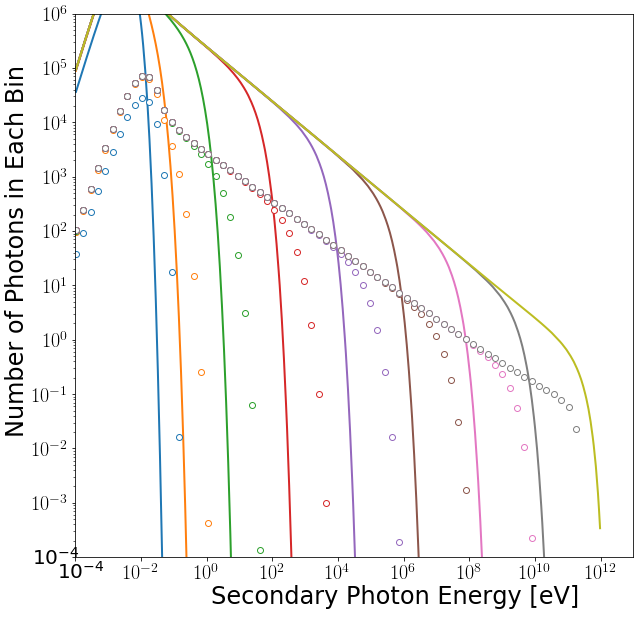

In [23]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([3.1e3, 3.1e5,3.1e6, 3.1e7, 3.1e8, 3.1e9, 3.1e10, 3.1e11, 3.1e12])

sec_phot_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

ICS_test_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=0, marker='o', markersize='6', 
    markerfacecolor='w', markevery=7,)
# sec_phot_tf.plot(ax, ind=145, fac=log_bin_width*sec_phot_tf.get_eng(), indtype='ind', linewidth=2)
# ICS_test_tf.plot(ax, ind=145, indtype='ind', linewidth=0, marker='o', markersize='6', 
#     markerfacecolor='w', markevery=10,)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Secondary Photon Energy [eV]',fontsize=24)

plt.ylabel('Number of Photons in Each Bin',fontsize=24)
plt.axis([1e-4, 1e13, 1e-4, 1e6])

## Moving Forward

To compare to the final code, we need to do the following. 

For the other processes, in the low-energy regime, we have the following things to calculate (there is no ICS, and the transfer function for ICS is simply the identity):

Process      | Sec. Low Energy Electrons            | Sec. Photons | Continuum | Deposited
-------------|--------------------------------------|--------------|-----------|-----------
ICS          |No                                    |No            |No         |No
Ionization   |Yes, resolved                         |No            |No         |Yes
Excitation   |Yes, resolved                         |No            |Yes        |Yes
Heating      |Yes, resolved                         |No            |No         |Yes

and in the high-energy regime (for the processes other than ICS, this is exactly the same as before). 

Process      |Sec. High Energy Electrons          | Sec. Photons | Continuum | Deposited
-------------|------------------------------------|--------------|-----------|-----------
ICS          |Yes, resolved                       |Yes           |Yes        |Yes
Ionization   |Yes, resolved                       |No            |No         |Yes
Excitation   |Yes, resolved                       |No            |Yes        |Yes
Heating      |Yes, resolved                       |No            |No         |Yes

Excitation will be a little confusing. For 1s -> 2p hydrogen excitation, the electron loses 10.2 eV, producing a secondary electron (which is resolved), and 10.2 eV is assigned to deposited. For 1s -> 2s, the electron loses 10.2 eV, but the photons produced are assigned to continuum. For He+, the electron loses ~21 eV (and resolved), producing a 21 eV photon. 13.6 eV should then be assigned to ionization deposited energy, and the remaining 7.4 eV assigned to heating (corresponding to a secondary electron that can only contribute to heating). 

In the final implementation, we will do the following instead (no low- or high-energy limits):

Process      |Sec. High Energy Electrons          | Sec. Photons | Deposited
-------------|------------------------------------|--------------|-----------
ICS          |Yes, resolved                       |Yes           |Yes
Ionization   |Yes, resolved                       |No            |Yes
Excitation   |Yes, resolved                       |Yes           |No
Heating      |Yes, resolved                       |No            |Yes

Things that go into 'continuum', like the upscattered CMB photons and the 10.2 eV and below photons emitted due to excitation, will now be added to the secondary photon spectrum instead. We will not have to consider the difference between the 21 eV, 10.2 eV and lower than 10.2 eV photons for excitation: those will be treated separately. 